In [47]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import os
import seaborn as sns
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
import pims
import pySPM as spm 
import trackpy as tp
import glob
from sxmreader import SXMReader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
n_range = range(103, 229)
N = len(n_range)
SXM_PATH = ["electromigration_25/Image_{0:03}.sxm".format(i) for i in n_range]
frames = SXMReader(SXM_PATH)
molecule_size = 13
min_mass = 1.7
max_size = 3
separation = 5
searchRange = 30

Frame 125: 56 features


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5c1f396940>,
      dtype=object)

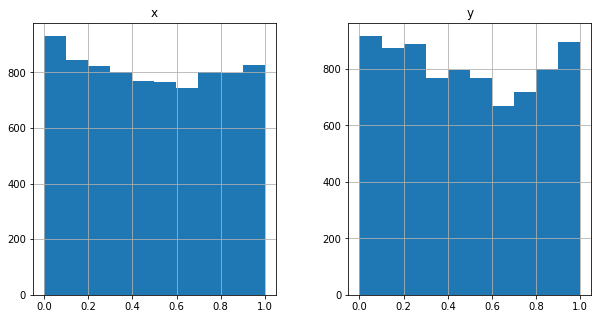

In [121]:
f = tp.batch(frames[:], 11, minmass=min_mass, maxsize=max_size, separation=separation)
tp.subpx_bias(f)

In [ ]:
plt.figure()

fig=plt.figure(figsize=(4, 3))
ax1=plt.axes(xlim=(0, 256), ylim=(0, 256), frameon=False)
ln, = ax1.plot([], [], lw=3)
plt.axis('off')

def update(i):
    tp.annotate(f[f['frame']==i], frames[i],  plot_style={'markersize': 0.5}, ax=ax1)
#     tp.annotate(f[f['frame']==i], frames[i],  plot_style={'markersize': 0,5}, ax=ax1)
    for line in ax1.lines[:-1]:
        line.set_marker(None)
    return ln,

ani = FuncAnimation(fig, update, frames=range(len(frames)), interval=100)
ani

Frame 125: 56 trajectories present.


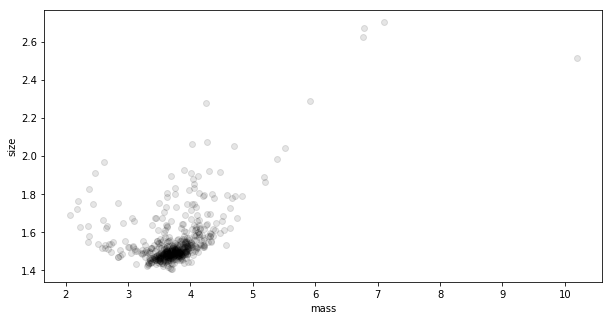

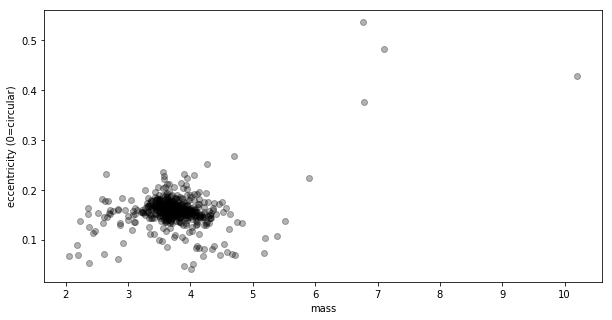

In [122]:
t = tp.link(f, search_range=searchRange, adaptive_stop=2.0, adaptive_step=0.95)
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass
tp.mass_ecc(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [123]:
t1 = t[( (t['size'] > 1) & (t['size'] < 1.8) & \
        (t['mass'] > 2.5) & (t['mass'] < 4.5) & \
         (t['ecc'] < 0.3))]
t2 = tp.filter_stubs(t, 10)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t2['particle'].nunique())

Before: 539
After: 221


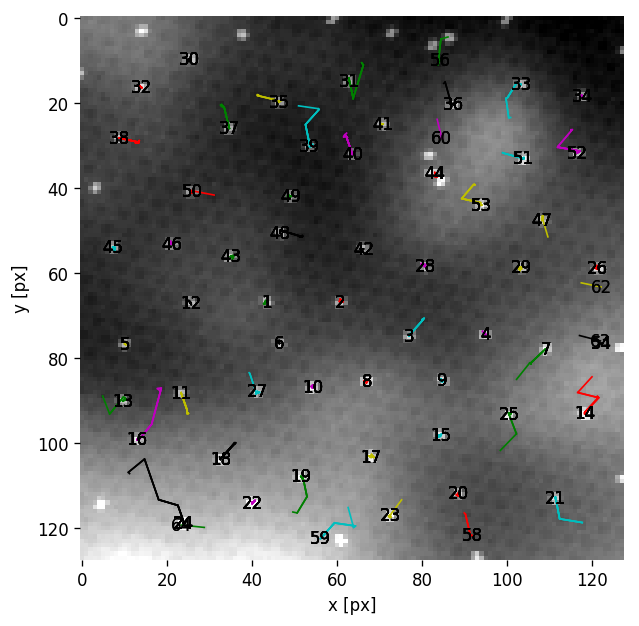

In [38]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

fig=plt.figure(figsize=(8, 6), dpi=120)
ax1=plt.axes(xlim=(0, 256), ylim=(0, 256), frameon=False)
# plt.axis('off')
ln, = ax1.plot([], [], lw=3)
ax1.set_prop_cycle(color=['g', 'r', 'c', 'm', 'y', 'k'])

def update(i):
    tp.plot_traj(t2[(t2['frame']<=i)], superimpose=frames[i], label=True, ax=ax1)
    ax1.set_prop_cycle(color=['g', 'r', 'c', 'm', 'y', 'k'])
    return ln,

ani = FuncAnimation(fig, update, frames=range(len(frames)), interval=1000)
ani

In [124]:
NM_PER_PIXEL = frames.meters_per_pixel * 1e9
d = tp.compute_drift(t2)
t3 = tp.subtract_drift(t2.copy(), d)
t3.reset_index(drop=True, inplace=True)

[20.56646095  0.89002858]


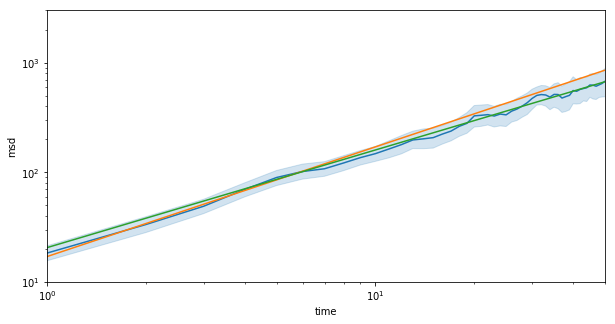

In [125]:
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
def msd(df):
    df['time'] = df['frame'] - df['frame'].iloc[0]
    x0, y0 = df.x.iloc[0], df.y.iloc[0]
    df['msd'] = (df.x - x0) ** 2 + (df.y - y0) ** 2
    return df
msds = t3.groupby('particle').apply(lambda x : msd(x))
# plt.figure(figsize=(5, 5))
sns.lineplot(data=msds, x='time', y='msd')
# sns.regplot(data=msds, x='time', y='msd', scatter=False)
ser = msds.groupby('time').msd.mean()
# ser.plot()
# msds.groupby('time').size().plot()
# (ser.iloc[1:] / 30).plot()
END_RANGE = 50
reg = LinearRegression(fit_intercept = False).fit(ser.index.values[1:5].reshape(-1, 1), ser.values[1:5])
def f(t, a, b):
    return a * t ** b
popt, pcov = curve_fit(f, ser.index.values[1:END_RANGE], ser.values[1:END_RANGE], bounds=[[0, 0], [np.inf, 1]])
print(popt)
plt.plot(ser.index.values, reg.predict(ser.index.values.reshape(-1, 1)), label='linear fit')
plt.plot(ser.index.values, f(ser.index.values, *popt), label='power law fit')
plt.xlim(1, END_RANGE)
plt.ylim(1e1, 3e3)
plt.yscale('log')
plt.xscale('log')

In [97]:
x1, msds1,  line1, fit1 = ser.index.values, msds, reg.predict(ser.index.values.reshape(-1, 1)), f(ser.index.values, *popt)

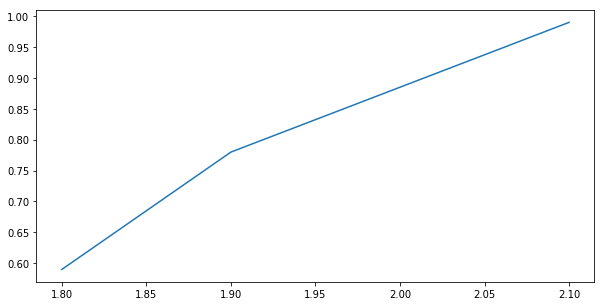

In [96]:
plt.plot([1.8, 1.9, 2.1], [0.59, 0.78, 0.99])

(0, 300)

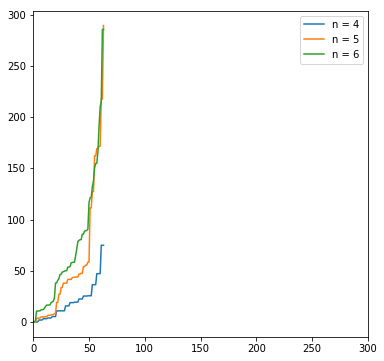

In [37]:
def pvariation(df, p, n, t=None):
    """p-variation for finite n.
    df: each trajectory data file
    p: power in p-variation formula
    n: n is the power in 2^n 
    t: max measurement time
    Frames beyond the highest power of 2 available are ignored.
    All intervals are constructed to be of equal length. T is assumed,
    without loss of generality, to equal the total number of frames included.
    
    """
    maxn = int(np.log2(len(df)) // 1)
    T = 2**maxn
    if t is None:
        t = T
    x = np.array(df['x'])
    y = np.array(df['y'])
    dt = T // 2**n
    ts = np.arange(2**n)*dt
    ts = ts[ts < t]  # Ignore frames greater than t
    total = 0.
    for i in range(len(ts) - 1):
        total += np.abs(x[ts[i+1]] - x[ts[i]])**p
    return total

tmp = t3[t3.particle == 1]

plt.figure(figsize=(6, 6))

for j in [4, 5, 6]:
    v_t = []
    for i in range(2 ** 6):
        v_t.append(pvariation(tmp, 2, j, t=i))
    plt.plot(v_t, label="n = {}".format(j))
plt.legend()
plt.xlim(0, 300)
plt.xlim(0, 300)